<h3>
Khai báo các thư viện cần thiết
</h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from private_module import visualize_orbit

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

Đọc dữ liệu từ file "measData.csv"

In [2]:
df = pd.read_csv("data/measData.csv")
df_ground_truth = pd.read_csv('data\groundtruthData.csv') # Lấy dữ liệu trong thực tế để đối chiếu

print("Các trường thuộc tính của dữ liệu measData:")
print(df.columns)

print()
print("Các trường thuộc tính của dữ liệu groundtruthData:")
print(df_ground_truth.columns)

print()
print("Năm dòng đầu tiên của bộ dữ liệu measData:")
print(df.head())

print()
print("Năm dòng đầu tiên của bộ dữ liệu groundtruthData:")
print(df_ground_truth.head())

Các trường thuộc tính của dữ liệu measData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (m)'], dtype='object')

Các trường thuộc tính của dữ liệu groundtruthData:
Index(['timeSeries', 'Azimuth (rad)', 'Range (m)', 'Speed (m/s)',
       'Heading (rad)'],
      dtype='object')

Năm dòng đầu tiên của bộ dữ liệu measData:
   timeSeries  Azimuth (rad)    Range (m)
0           0      -2.619192  200076.6746
1          10      -2.622475  198853.7752
2          20      -2.622916  197974.2480
3          30      -2.633978  196907.8388
4          40      -2.622791  195972.3070

Năm dòng đầu tiên của bộ dữ liệu groundtruthData:
   timeSeries  Azimuth (rad)    Range (m)  Speed (m/s)  Heading (rad)
0           0      -2.619852  200000.0000          120       1.049056
1          10      -2.622887  198963.9228          120       1.049056
2          20      -2.625954  197929.6974          120       1.049056
3          30      -2.629053  196897.3532          120       1.049056
4          40      -2.6321

<h4>
    Nội dung của bộ dữ liệu: 
</h4>

Bộ dữ liệu “measData.csv” chứa thông tin quỹ đạo của một mục tiêu phát hiện bởi Radar với các giá trị trong các thuộc tính có ý nghĩa như sau:
+ Cột "Time Series": Cho biết thời điểm của mục tiêu tại vị trí đấy (giây - gốc thời gian là 0s), cột dữ liệu này đơn điệu tăng, tỉ lệ thuận gấp 10 với chỉ số của từng hàng dữ liệu
+ Cột “Azimuth”: giá trị phương vị (góc hình học, gốc tại 3h, tăng ngược chiều kim đồng hồ). Đơn vị: radian
+ Cột “Range”: giá trị cự ly (khoảng cách đến tâm đài Radar). Đơn vị: mét

Nội dung của 3 cột thuộc tính được minh hoạ trong ảnh dưới đây: 
    
<center>
      <img src="./img_for_notebook/polar_coordinate.jpg" alt="Ảnh minh hoạ 3 thuộc tính">
</center>

<h3>
    Thực hiện thống kê mô tả để hiểu hai bộ dữ liệu
</h3>

<h4>
    Đối với bộ dữ liệu từ radar (measData)
</h4>

Kiểm tra sự tồn tại của giá trị null trong bộ dữ liệu

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timeSeries     500 non-null    int64  
 1   Azimuth (rad)  500 non-null    float64
 2   Range (m)      500 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


--> Không có sự tồn tại giá trị null trong các cột dữ liệu

Trước tiên, ta sẽ cùng thử xem qua các tham số đặc trưng, và các biểu đồ hộp của thuộc tính

In [4]:
df.describe()

,timeSeries,Azimuth (rad),Range (m)
count,500.000000,500.000000,500.000000
mean,2495.000000,0.338989,130133.787614
std,1444.818328,1.966283,49302.402205
min,0.000000,-3.135104,53291.338400
25%,1247.500000,-2.633359,93822.983782
50%,2495.000000,1.190902,127094.953800
75%,3742.500000,1.387258,159423.774875
max,4990.000000,3.146498,252131.570500


In [5]:
df_ground_truth.describe()

,timeSeries,Azimuth (rad),Range (m),Speed (m/s),Heading (rad)
count,500.000000,500.000000,500.000000,500.0,500.000000
mean,2495.000000,0.339928,130143.015414,120.0,0.827312
std,1444.818328,1.966400,49306.534278,0.0,0.948417
min,0.000000,-3.132285,53350.504760,120.0,-3.122281
25%,1247.500000,-2.632975,93779.647502,120.0,0.398921
50%,2495.000000,1.196307,127151.719000,120.0,0.918156
75%,3742.500000,1.392863,159456.377300,120.0,1.049056
max,4990.000000,3.139154,252156.450700,120.0,3.073638


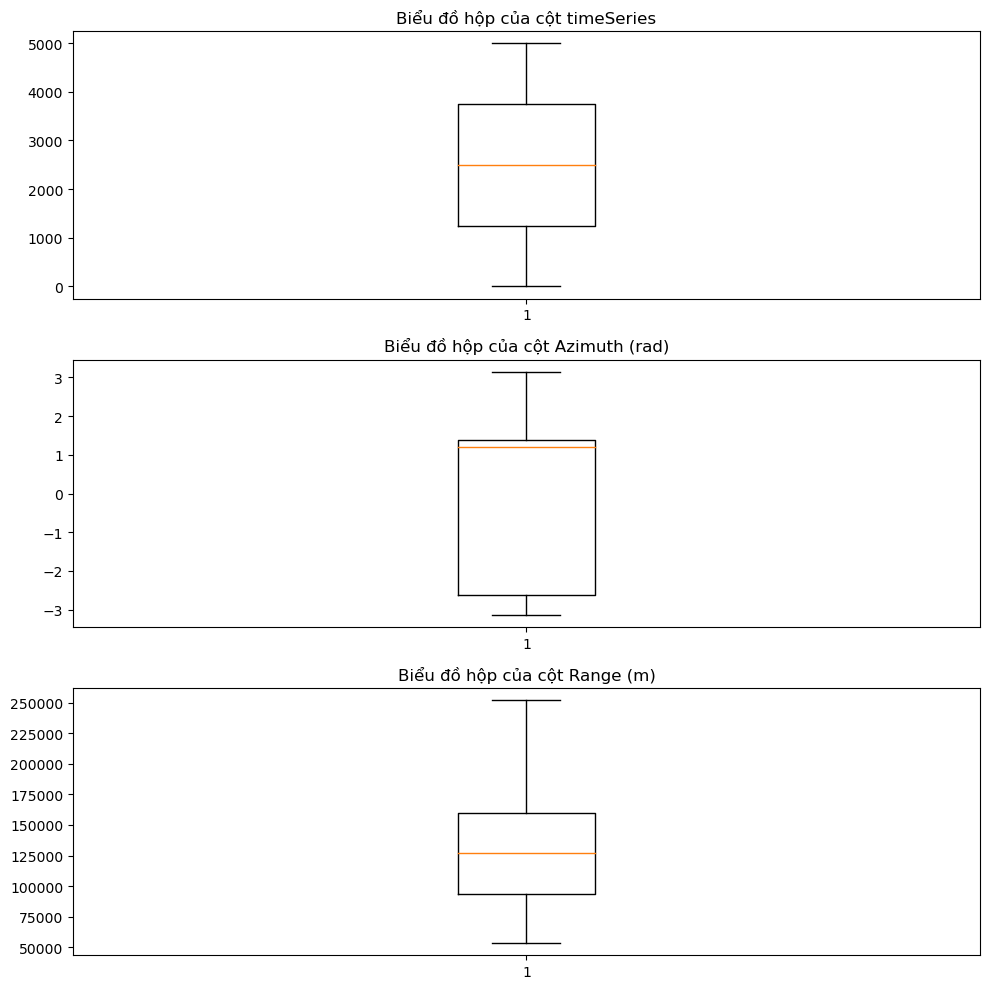

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))


# Iterate through the subplots and plot some data
for i, ax in enumerate(axes.flat):
    ax.boxplot(df[df.columns[i]])
    ax.set_title(f"Biểu đồ hộp của cột {df.columns[i]}")


plt.tight_layout()  # Làm cho các chữ không bị dính vào nhau
plt.show()

Tiếp theo, ta sẽ thể hiện tần suất đồ của các giá trị trong các cột thuộc tính kết hợp với biểu đồ đường (Do các cột thuộc tính có giá trị theo chuỗi thời gian nên trục hoành có thể xem là sự biểu hiện của thuộc tính thời gian)

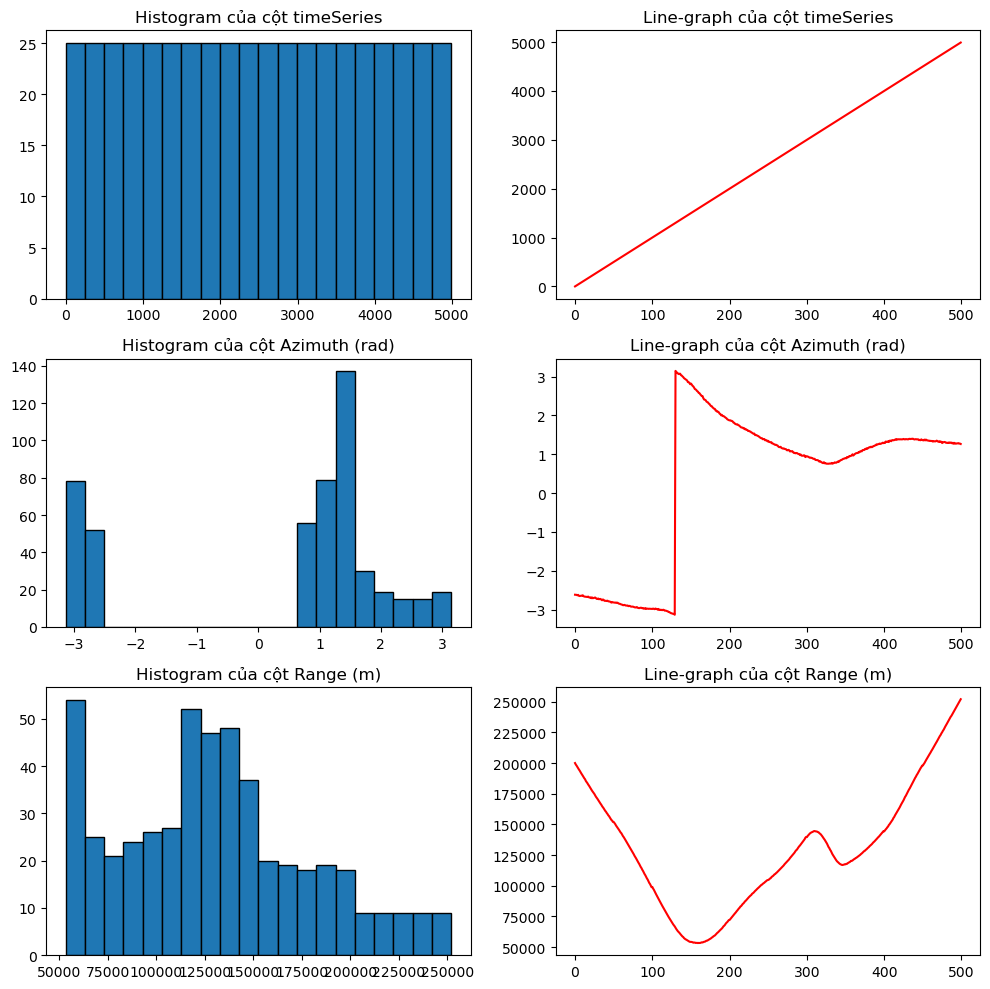

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))


# Iterate through the subplots and plot some data
for i in range(3):
    for j in range(2):
        if j % 2 == 0:
            ax[i][j].hist(df[df.columns[i]], bins=20, edgecolor = "black")
            ax[i][j].set_title(f"Histogram của cột {df.columns[i]}")
        else:
            ax[i][j].plot(df[df.columns[i]], color = "r")
            ax[i][j].set_title(f"Line-graph của cột {df.columns[i]}")

    
plt.tight_layout()  # Làm cho các chữ không bị dính vào nhau

plt.show()


**Nhận xét:**
+ Dữ liệu timeSerie tỉ lệ tuyến tính với chỉ số của hàng khi quan sát trên đồ thị (với tỷ lệ cụ thể là 10).
    <br>
+ Trong biểu đồ đường của cột dữ liệu Azimuth (Góc phương vị), có sự gián đoạn dữ liệu tại một điểm có giá trị trên trục hoành vào khoảng (1200s, 1400s). Điều này có thể giải thích là do trong khoảng thời gian đấy, mục tiêu đang di chuyển từ góc phần tư thứ III sang đến góc phần tư thứ II (trên trục toạ độ Descartes, với gốc toạ độ là vị trí Radar), để thể hiện sự liên tục, ta có thể thay đổi các giá trị góc phương vị âm sang các giá trị dương tương ứng.
    <br>
+ Cùng với đó, ở biểu đồ đường của cột Azimuth và cột Range không có tính tuần hoàn, đặc biệt cột Range có xu hướng nghịch biến ở thời điểm đầu, sau đó đồng biến ở thời gian ước tính (1400s - 1600s), sau đó có sự nghịch biến nhẹ trước khi tiếp tục đồng biến, nên có thể nhận định rằng: Mục tiêu không di chuyển quanh Radar mà đang di chuyển từ xa lại gần và tiếp tục di chuyển ra xa.

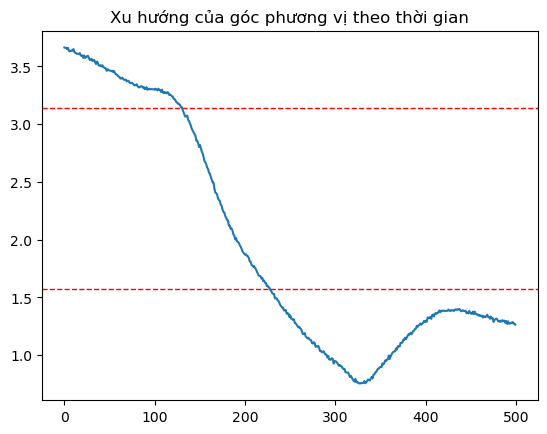

In [8]:
# Thay đổi các giá trị góc phương vị âm để đồng nhất và dễ quan sát trên đồ thị

df.loc[df['Azimuth (rad)'] < 0, 'Azimuth (rad)'] = 2 * np.pi + df['Azimuth (rad)']


plt.axhline(y=np.pi, color='red', linewidth=1, linestyle = "--")
plt.axhline(y=np.pi / 2, color='red', linewidth=1, linestyle = "--")

plt.title("Xu hướng của góc phương vị theo thời gian")
plt.plot(df['Azimuth (rad)'])
plt.show()

<h4>
    Trực quan hoá quỹ đạo của mục tiêu
</h4>

Quỹ đạo của mục tiêu được thể hiện trên mặt phẳng 2D

Trước tiên, ta thêm vào dữ liệu các cột thuộc tính về các giá trị trục hoành (x-axis) và trục tung (y-axis) sau khi đã biết hai thông tin về góc phương vị (Azimuth) và khoảng cách (Range). Hai giá trị này này được tính bằng công thức sau:
<center>
    $x = \cos(\alpha) \cdot d$
    <br>
    $y = \sin(\alpha) \cdot d$
    
    
</center>
<p style="padding-left: 8cm;">
    Trong đó $\alpha$: Góc phương vị; $d$: Khoảng cách (range)
</p>

Để thuận tiện cho việc trực quan, ta cũng sẽ giảm thuộc tính Range đi 1000 lần (về đơn vị km)

In [9]:
df['Range (m)'] = df['Range (m)'] / 1000

df['x-axis'] = np.cos(df['Azimuth (rad)']) * df['Range (m)']
df['y-axis'] = np.sin(df['Azimuth (rad)']) * df['Range (m)']

# Đổi lại tên thuộc tính cho phù hợp
df = df.rename(columns={'Range (m)': 'Range (km)'})

df.head()

,timeSeries,Azimuth (rad),Range (km),x-axis,y-axis
0,0,3.663993,200.076675,-173.391253,-99.830602
1,10,3.660711,198.853775,-172.656196,-98.654255
2,20,3.660269,197.974248,-171.935899,-98.141987
3,30,3.649208,196.907839,-172.079002,-95.715799
4,40,3.660394,195.972307,-170.185084,-97.170893


Lưu lại dữ liệu trên

In [10]:
df.to_csv('data/measData_ver2.csv', index=False)

Trực quan hoá quỹ đạo của mục tiêu trên trục toạ độ Descartes:


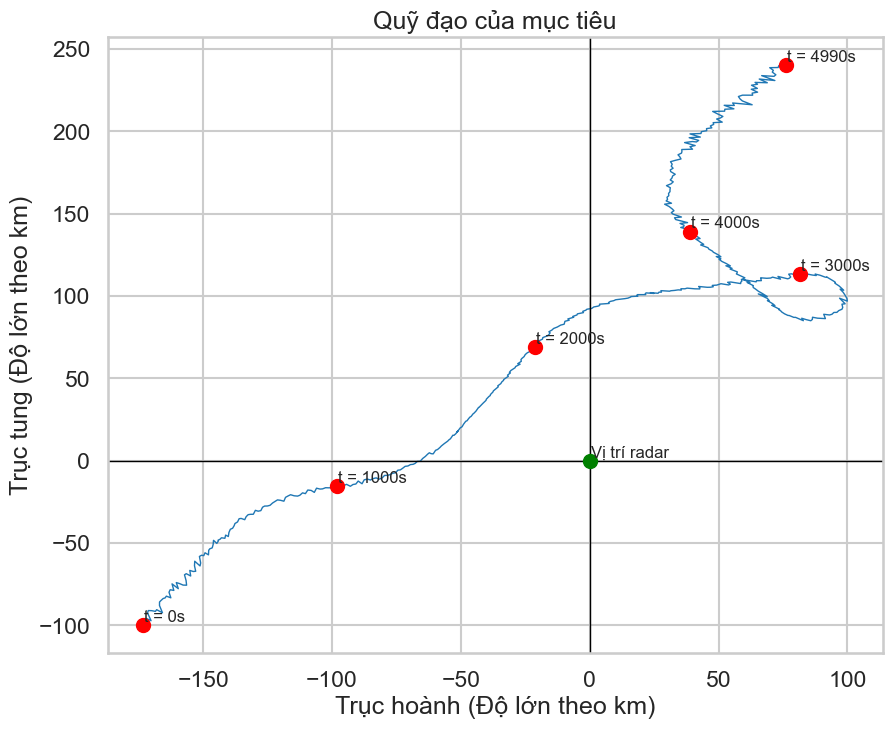

In [11]:
visualize_orbit.plot_orbit(df)

In [12]:
# Độ lệch của meas và truth

In [13]:
df = pd.read_csv("data/measData_ver2.csv")
df_ground_truth = pd.read_csv('data/groundtruthData_ver2.csv') # Lấy dữ liệu trong thực tế để đối chiếu

In [14]:
# Using MED

distance_error = np.sqrt((df['x-axis'] - df_ground_truth['x-axis']) ** 2 + (df['y-axis'] - df_ground_truth['y-axis']) ** 2)

mean_error_distance = np.mean(distance_error)
mean_error_distance


0.8942690597173115

In [15]:
intervals_num = 10

quan_interval = len(df) // intervals_num

MED = []

for i in range(intervals_num):
    MED.append(np.mean(distance_error[i * quan_interval:(i + 1) * quan_interval]))
    
MED

[1.2751157146787617,
 0.6415516247000806,
 0.50689935300584,
 0.43808571042936295,
 0.6165631428219435,
 1.0033726367753295,
 0.8495073440382486,
 0.9210835022604735,
 1.0851012009708345,
 1.605410367492236]

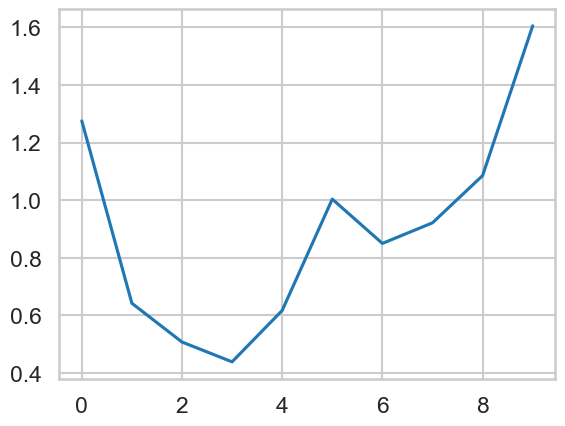

In [16]:
plt.plot(MED)

In [17]:
MED = np.array(MED)


In [18]:

print(np.mean(MED))
print(np.std(MED))
print(np.min(MED))
print(np.max(MED))

0.8942690597173112
0.34654790036682326
0.43808571042936295
1.605410367492236


In [19]:
1.6054 - 0.4381

1.1673

In [20]:
x_err = df['x-axis'] - df_ground_truth['x-axis']
y_err = df['y-axis'] - df_ground_truth['y-axis']

x_err, y_err

(0     -0.000662
 1      0.136328
 2      0.258556
 3     -0.482614
 4      0.813236
          ...   
 495   -1.021499
 496   -3.164342
 497   -0.634123
 498   -1.078642
 499    1.044333
 Name: x-axis, Length: 500, dtype: float64,
 0     -0.152606
 1     -0.016602
 2     -0.544678
 3      0.841166
 4     -1.654271
          ...   
 495    0.266466
 496    0.922910
 497    0.079289
 498    0.264678
 499   -0.354990
 Name: y-axis, Length: 500, dtype: float64)

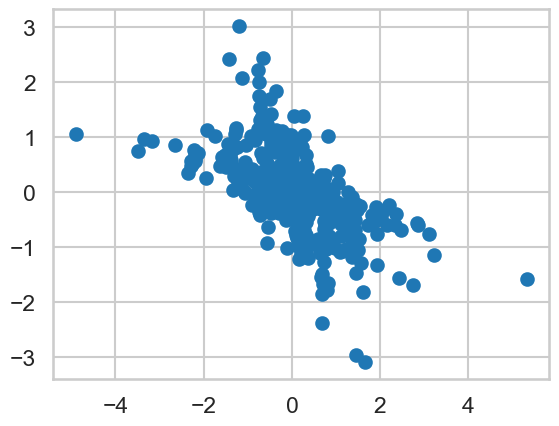

In [21]:
plt.scatter(x_err, y_err)

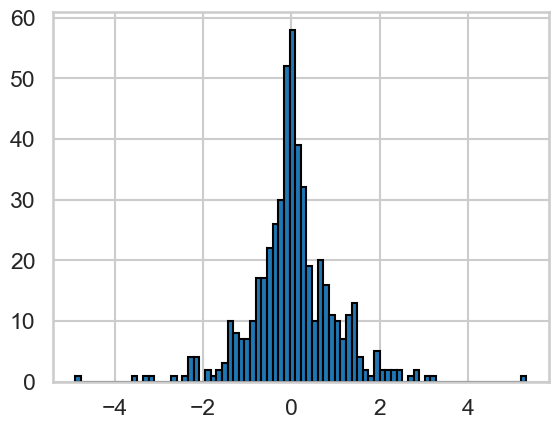

In [44]:
%matplotlib inline
plt.hist(x_err, bins=80, edgecolor='black')
plt.show()

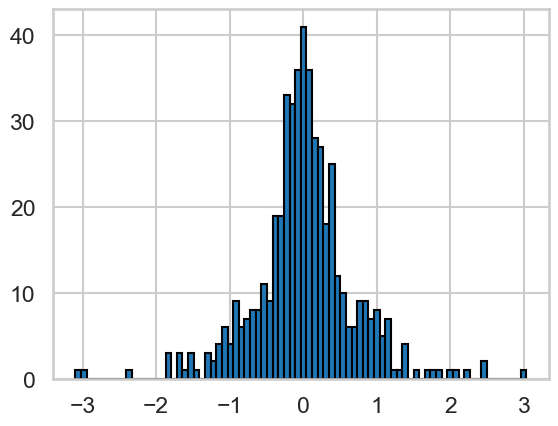

In [45]:
%matplotlib inline
plt.hist(y_err, bins=80, edgecolor='black')
plt.show()

In [34]:
np.cov(x_err, y_err), np.mean(x_err), np.mean(y_err)

(array([[ 0.93297419, -0.38742827],
        [-0.38742827,  0.45921519]]),
 0.047739656187563685,
 0.0113532984207827)

In [33]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import kstest

# Define the parameters of the 2D Gaussian distribution
mean = np.array([0, 0])  # Mean of the Gaussian distribution
covariance = np.cov(x_err, y_err)  # Covariance matrix of the Gaussian distribution

# Generate the 2D Gaussian distribution
gaussian_dist = multivariate_normal(mean=mean, cov=covariance)

# Generate your dataset z with 30 rows and 2 values per row (assuming it's a numpy array)

# Extract x and y coordinates from the dataset
x = x_err
y = y_err

# Combine x and y coordinates into a 2D array
data = np.column_stack((x, y))

# Perform the Kolmogorov-Smirnov test to compare your dataset against the 2D Gaussian distribution
kstest_result = kstest(data, gaussian_dist.cdf)

# Extract the p-value from the test result
p_value = kstest_result.pvalue

# Set the significance level (e.g., alpha = 0.05)
alpha = 0.05

# Compare the p-value against the significance level
if p_value > alpha:
    print("The dataset z likely follows a 2D Gaussian distribution.")
else:
    print("The dataset z does not follow a 2D Gaussian distribution.")

print(p_value)

The dataset z does not follow a 2D Gaussian distribution.
0.0
